In [22]:
# Fix randomness and hide warnings
seed = 42
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import acf, pacf
from scipy.fft import fft
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas import Series
from sklearn.model_selection import train_test_split
import seaborn as sns
plt.rc('font', size=16)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

In [2]:
# Load Data

categories = np.load("training_dataset/categories.npy")
training_data = np.load("training_dataset/training_data.npy")
valid_periods = np.load("training_dataset/valid_periods.npy")

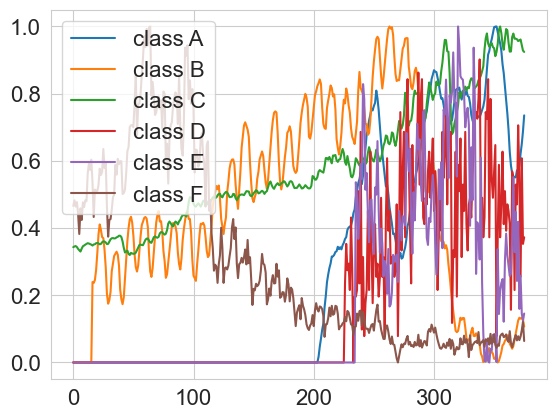

In [3]:
# Visualize one timeseries example for each class in the dataset.

plt.figure()
for c in np.unique(categories):
    c_x_train = training_data[categories == c]
    plt.plot(c_x_train[random.randrange(len(c_x_train))][2400:], label="class " + str(c))
plt.legend(loc="best")
plt.show()
plt.close()

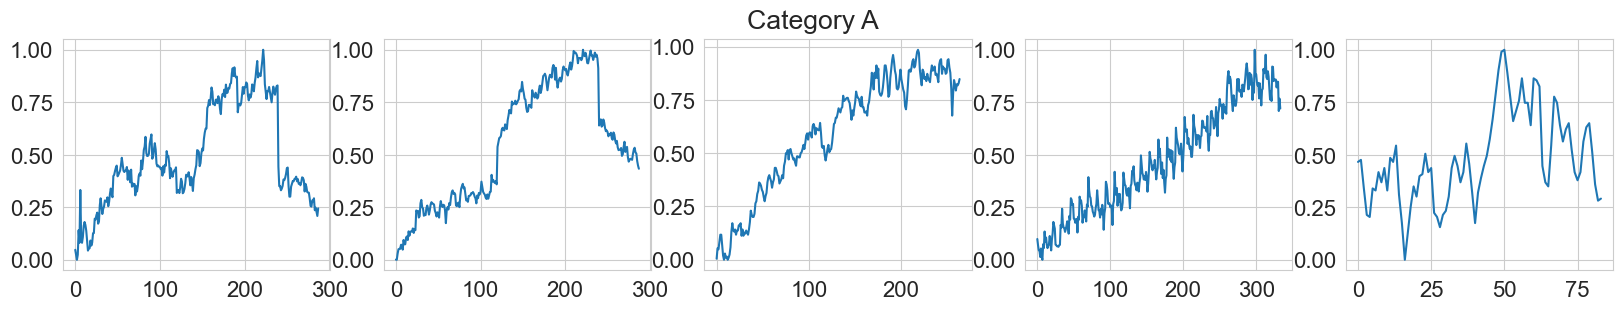

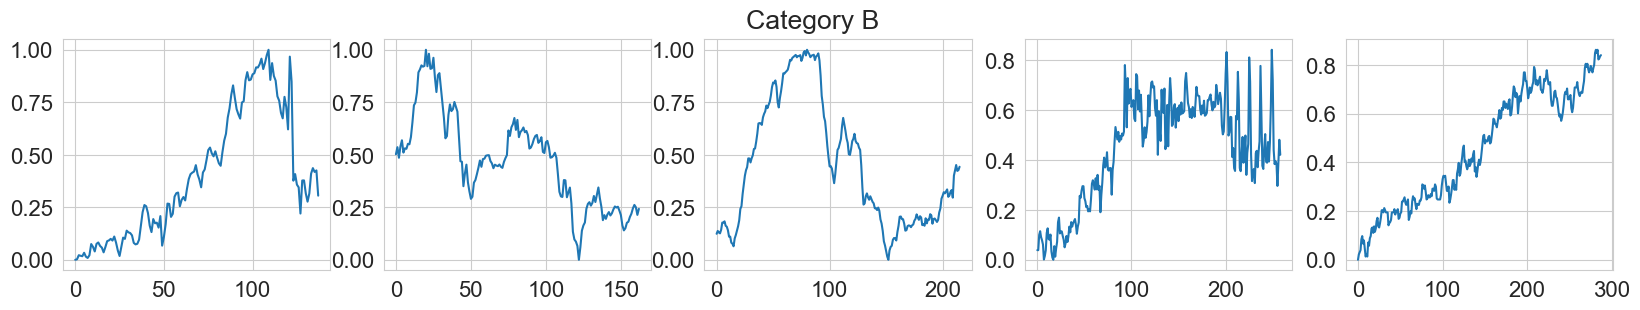

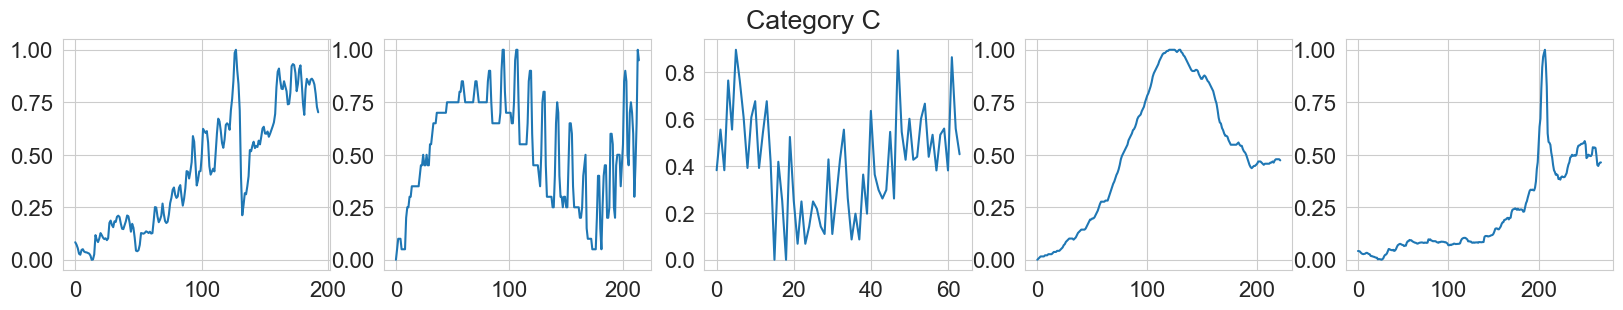

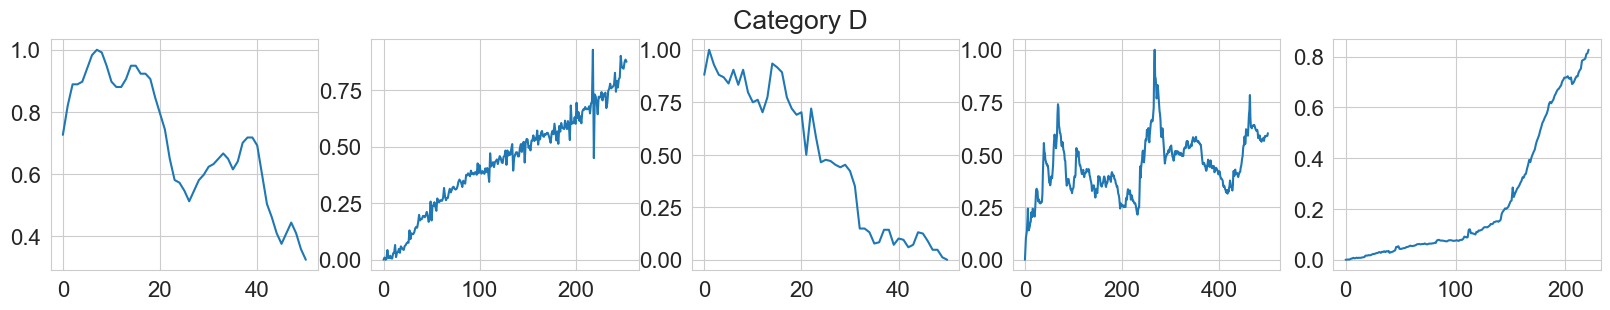

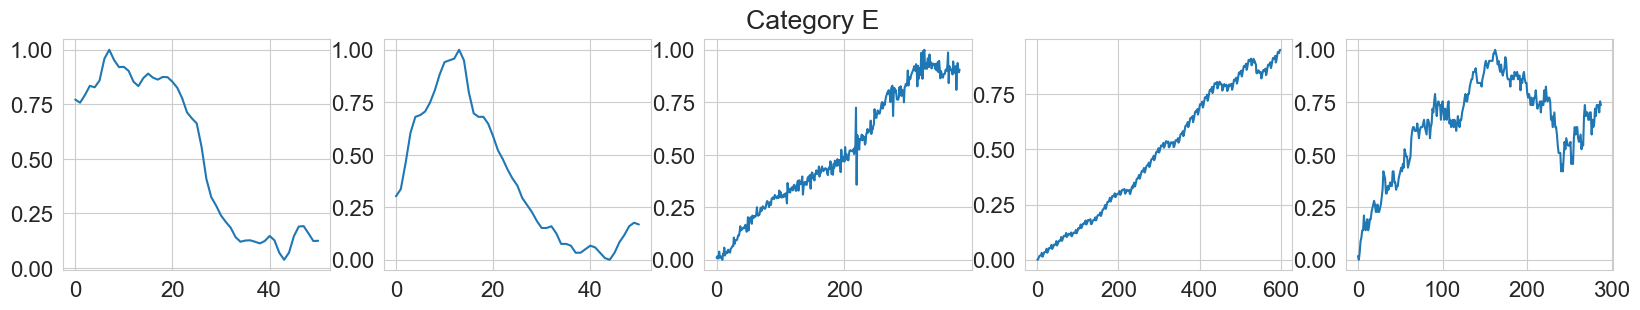

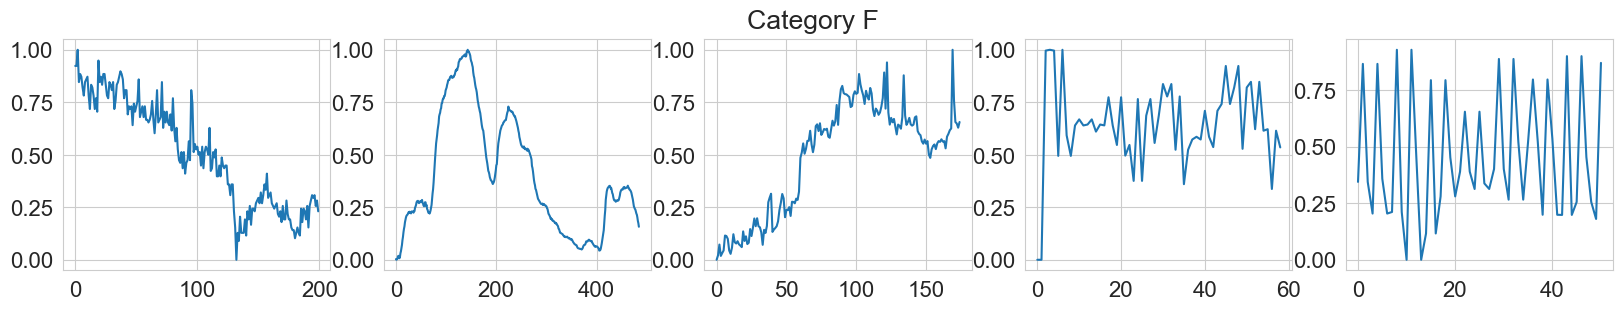

In [4]:
# Visualize some timeseries example for each class

for c in np.unique(categories):
    n_samples = 5
    fig, axs = plt.subplots(1, n_samples, figsize=(20, 3))
    timeseries = training_data[categories==c]
    periods = valid_periods[categories==c]
    fig.suptitle("Category " + c)
    for i in range(n_samples):
        index = random.randrange(len(timeseries))
        axs[i].plot(timeseries[index][periods[index, 0] : periods[index, 1]])
    plt.show()
    plt.close()

<Figure size 640x480 with 0 Axes>

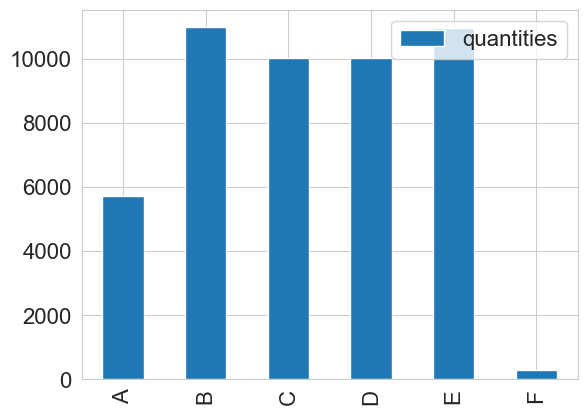

   quantities
A        5728
B       10987
C       10017
D       10016
E       10975
F         277


In [5]:
# Classes and quantities

classes, quantities = np.unique(categories, return_counts=True)
quantities = pd.DataFrame(quantities, index=classes, columns=['quantities'])
plt.figure()
quantities.plot(kind='bar')
plt.show()
plt.close()
print(quantities)

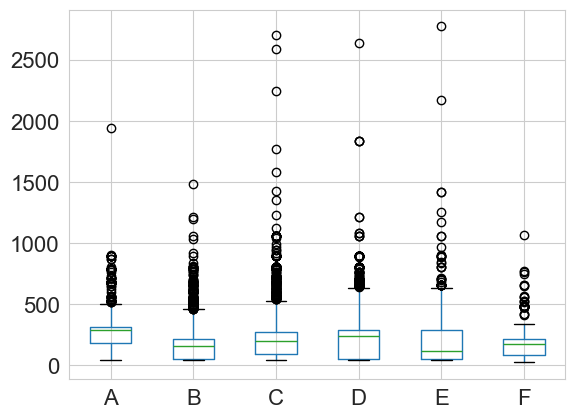

In [6]:
# Durations

plt.figure()
durations = pd.DataFrame()
for c in np.unique(categories):
    dur = pd.DataFrame(valid_periods[categories == c, 1] - valid_periods[categories == c, 0], columns=[c])
    durations = pd.concat([durations, dur], axis=1)
durations.boxplot()
plt.show()
plt.close()

In [40]:
def findMaxLocalMaxima(ts):
    localMax = 0
    for i in range(1, len(ts) - 1):
        prev = ts[i-1]
        curr = ts[i]
        next = ts[i+1]
        if curr > prev and curr > next and curr > localMax:
            localMax = i
    return None if localMax is 0 else localMax

288
145
288
145
313
157
166
84
168
85


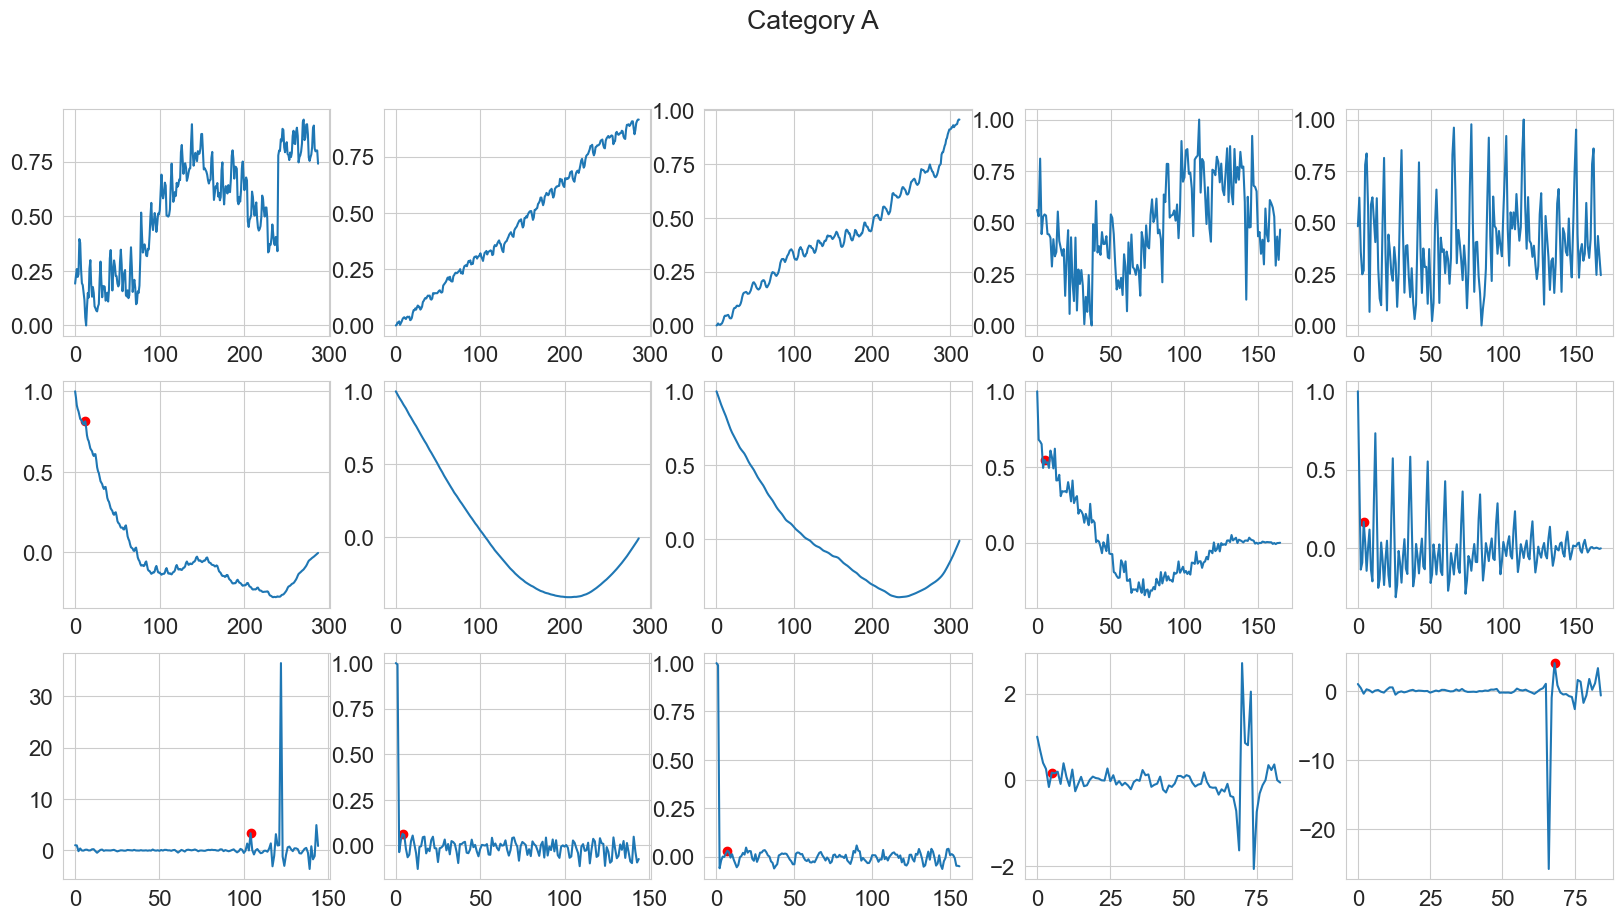

157
79
48
25
144
73
47
24
373
187


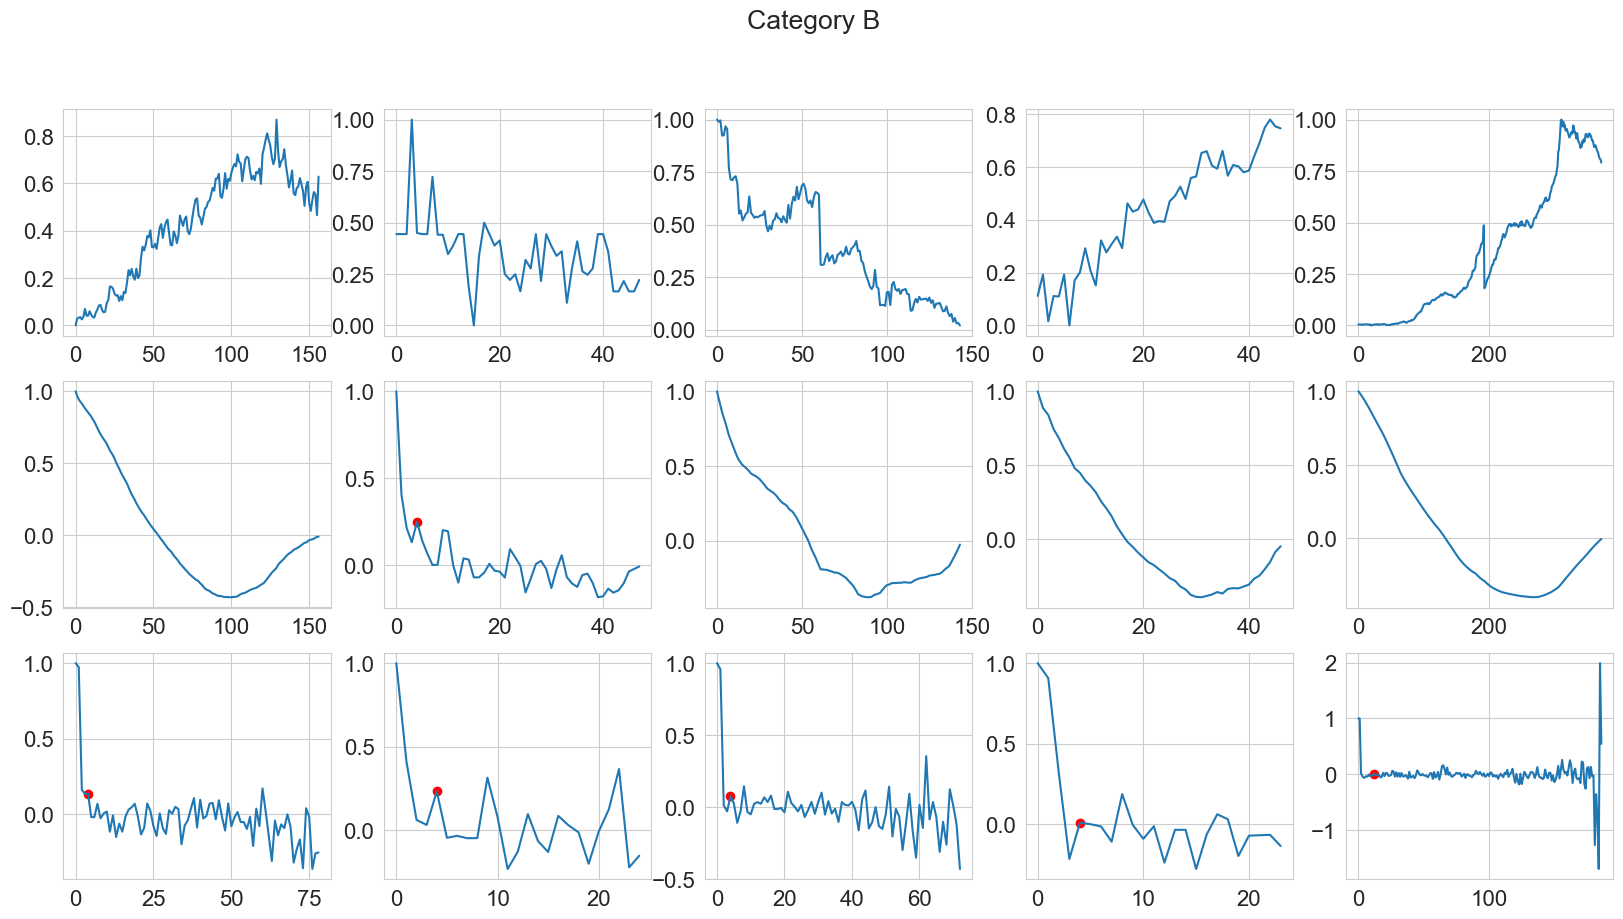

504
253
225
113
325
163
215
108
43
22


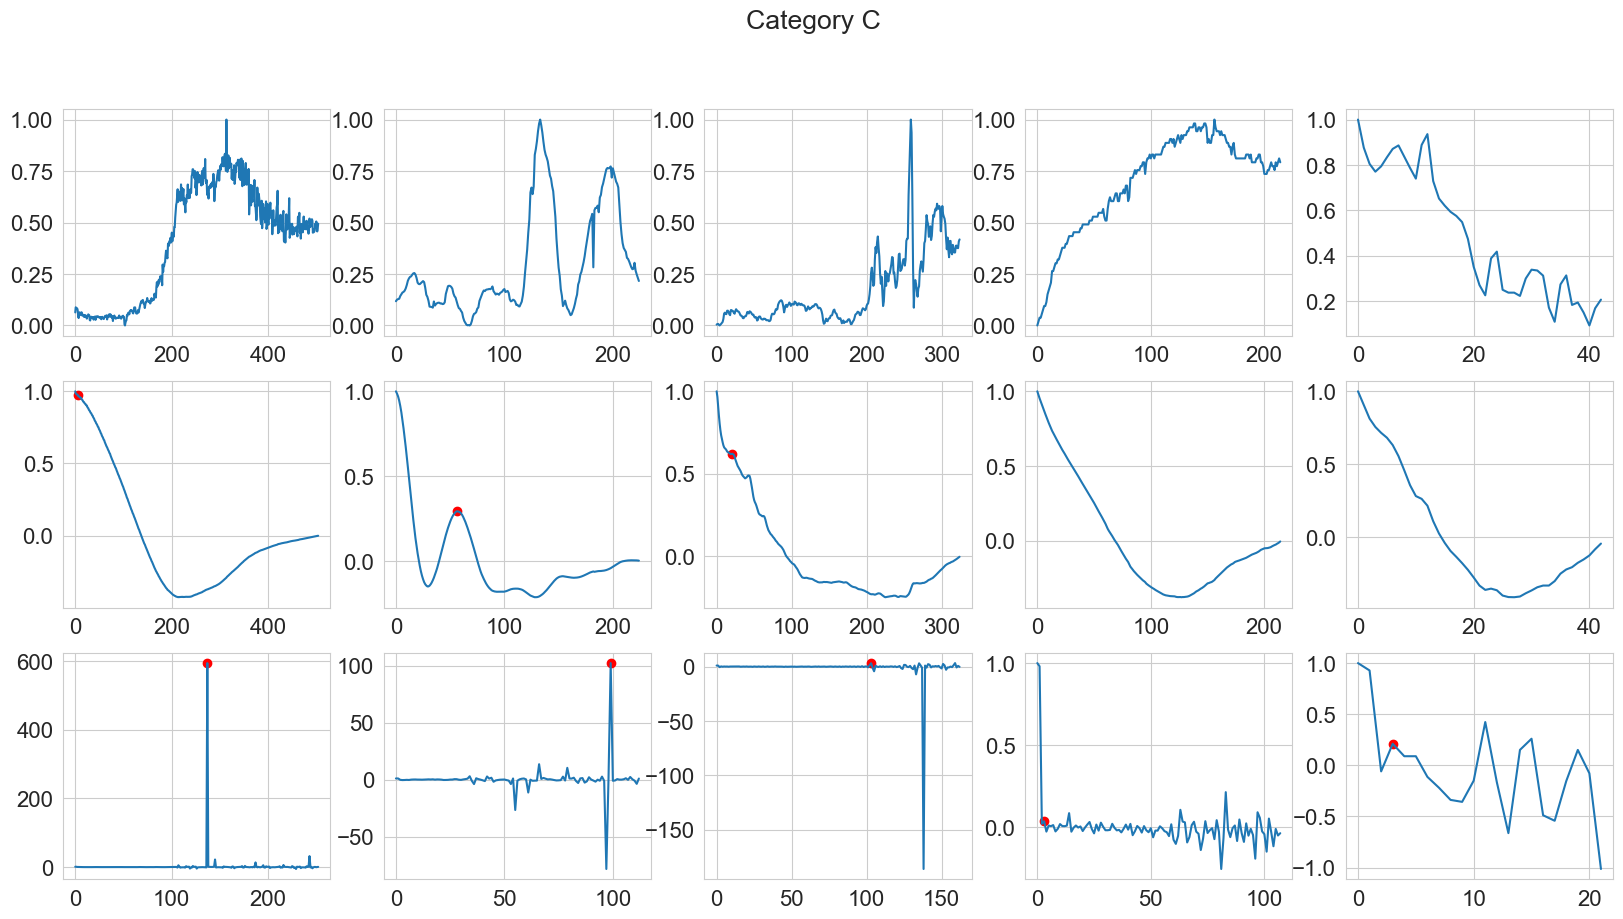

233
117
271
136
288
145
86
44
459
230


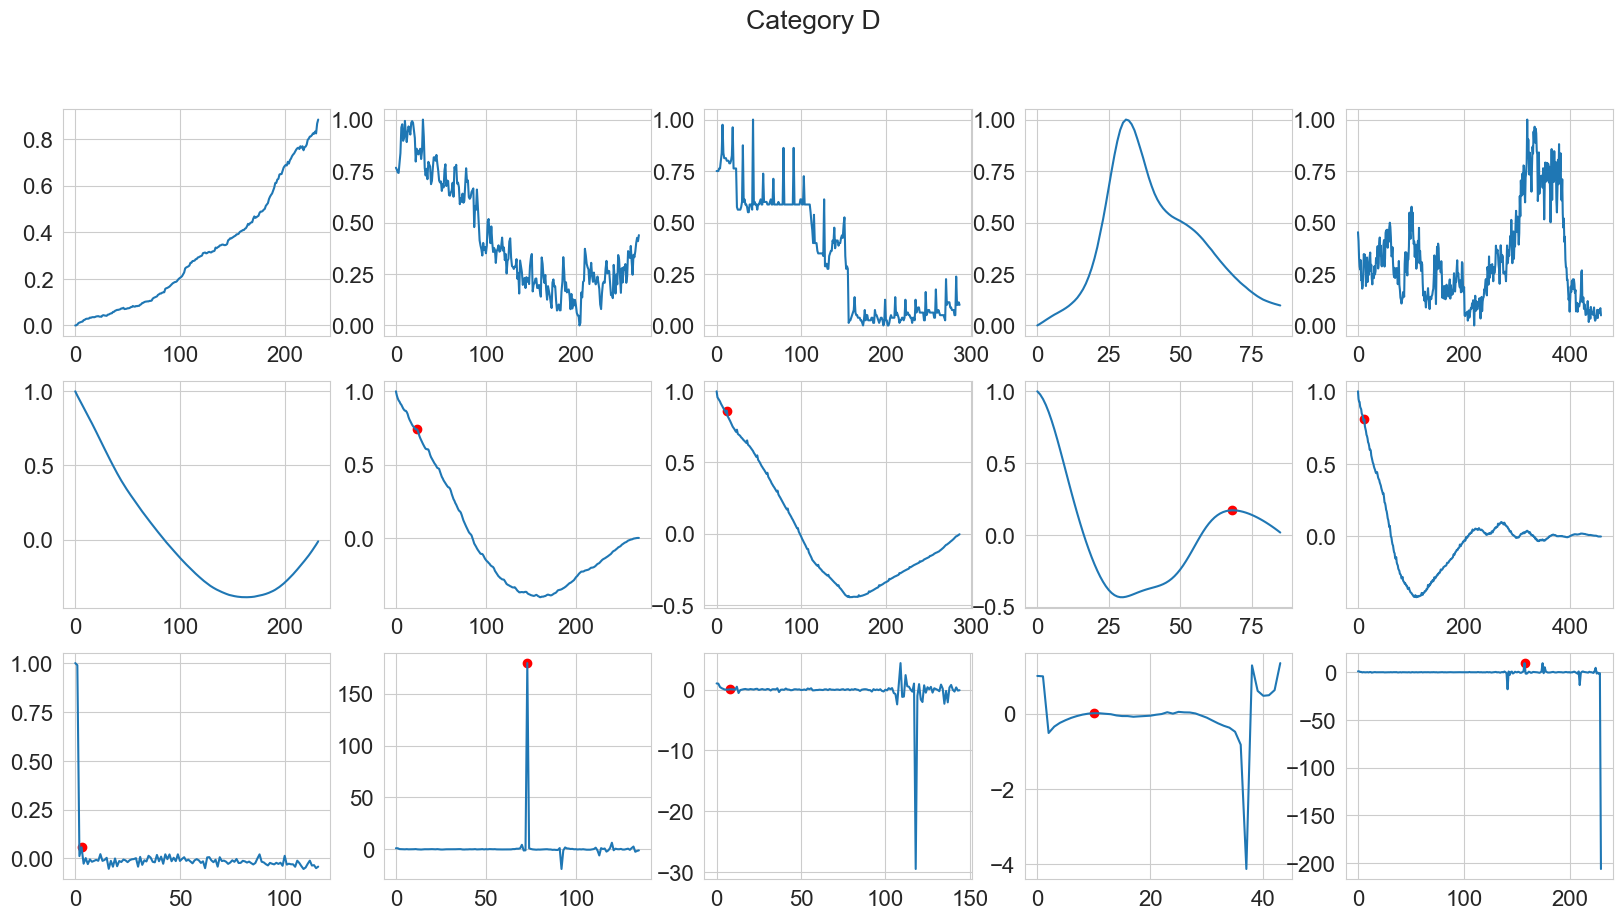

237
119
51
26
51
26
168
85
51
26


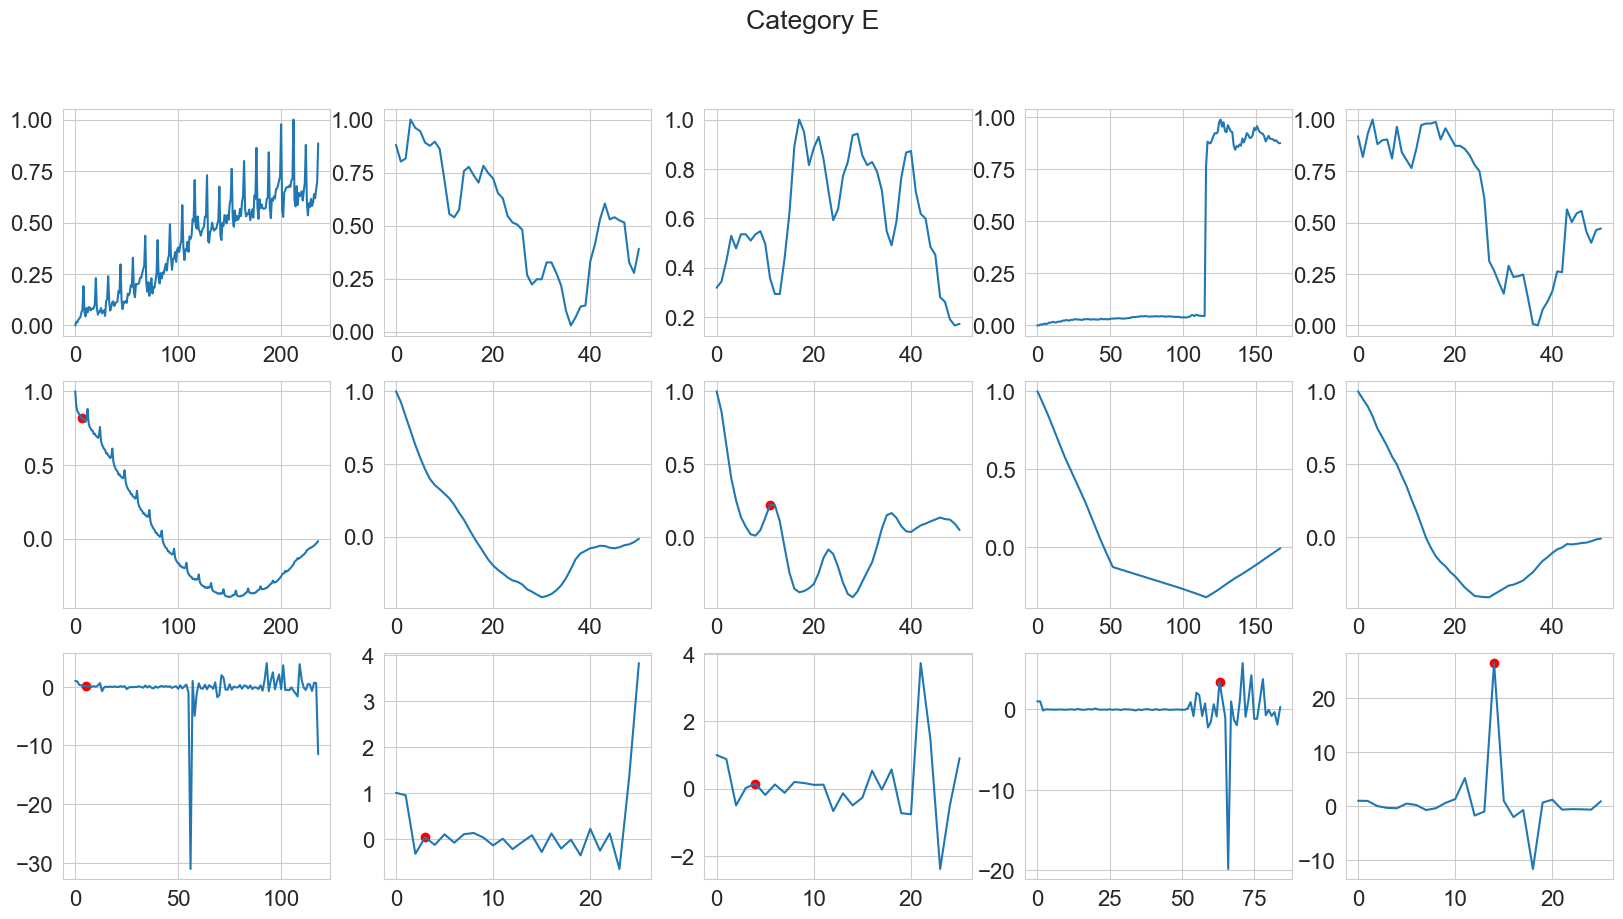

278
140
172
87
58
30
172
87
200
101


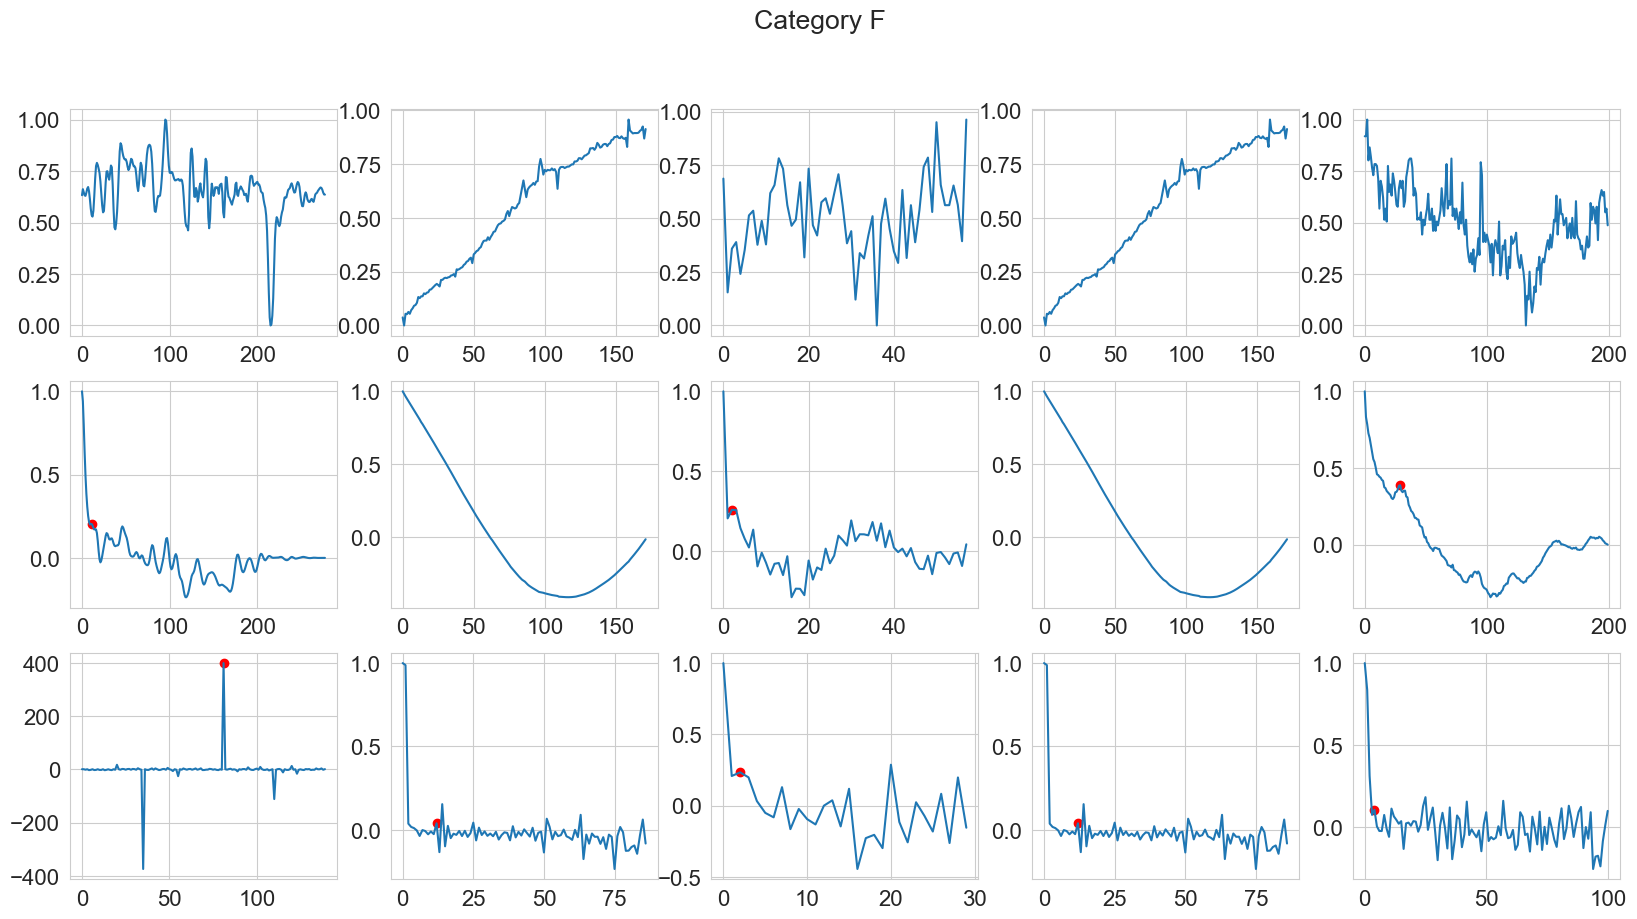

In [39]:
# Autocorrelation

for c in np.unique(categories):
    n_samples = 5
    fig, axs = plt.subplots(3, n_samples, figsize=(20, 10))
    timeseries = training_data[categories==c]
    periods = valid_periods[categories==c]
    fig.suptitle("Category " + c)
    for i in range(n_samples):
        index = random.randrange(len(timeseries))
        ts = timeseries[index][periods[index, 0] : periods[index, 1]]
        ac = acf(ts, nlags=len(ts))
        pac = pacf(ts, nlags=len(ts)//2)
        estimatedWindow_ac = findMaxLocalMaxima(ac)
        estimatedWindow_pac = findMaxLocalMaxima(pac)
        axs[0, i].plot(ts) 
        axs[1, i].plot(ac)
        if estimatedWindow_ac is not None:
            axs[1, i].scatter([estimatedWindow_ac], [ac[estimatedWindow_ac]], color="red")
        axs[2, i].plot(pac)
        if estimatedWindow_pac is not None:
            axs[2, i].scatter([estimatedWindow_pac], [pac[estimatedWindow_pac]], color="red")
    plt.show()
    plt.close()

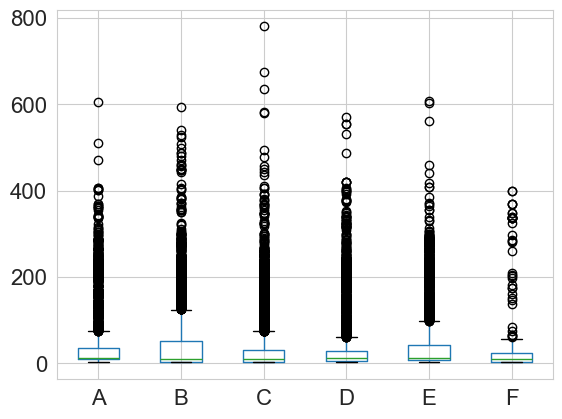

Number of timeseries with valid window size:
   total  valid  not valid          %
A   5728   4172       1556  27.164804
B  10987   7209       3778  34.386093
C  10017   7105       2912  29.070580
D  10016   6501       3515  35.093850
E  10975   6460       4515  41.138952
F    277    185         92  33.212996
Window size mean for category :
A    41.986577
B    42.185601
C    34.352287
D    31.125365
E    38.853715
F    56.275676
dtype: float64


In [41]:
# Window size inference with autocorrelation
plt.figure()
windowSizes = pd.DataFrame()
for c in np.unique(categories):
    timeseries = training_data[categories==c]
    periods = valid_periods[categories==c]
    ws = []
    for ts, p in zip(timeseries, periods):
        ac = acf(ts[p[0]:p[1]], nlags=len(ts))
        ws.append(findMaxLocalMaxima(ac))
    ws = pd.DataFrame(ws, columns=[c])
    windowSizes = pd.concat([windowSizes, ws], axis=1)
windowSizes.boxplot()
plt.show()
plt.close()

print("Number of timeseries with valid window size:")
n_notValid = pd.concat([quantities, windowSizes.count()], axis=1)
n_notValid.columns = ['total', 'valid']
n_notValid['not valid'] = n_notValid['total'] - n_notValid['valid']
n_notValid['%'] = n_notValid['not valid'] / n_notValid['total'] * 100
print(n_notValid)

print("Window size mean for category :")
print(windowSizes.mean())

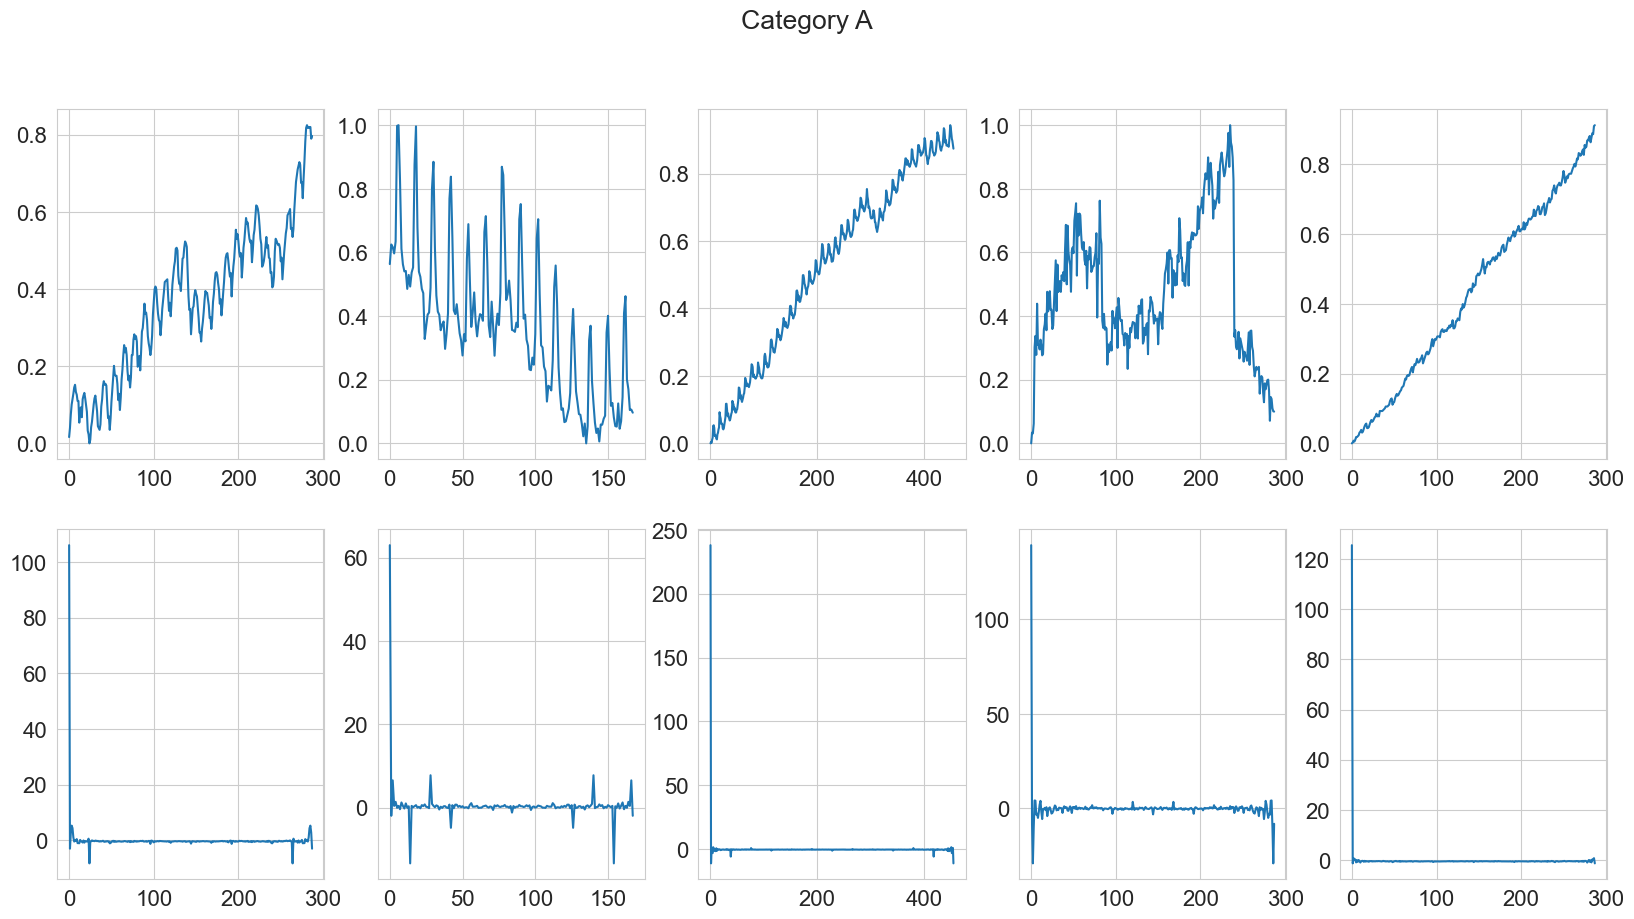

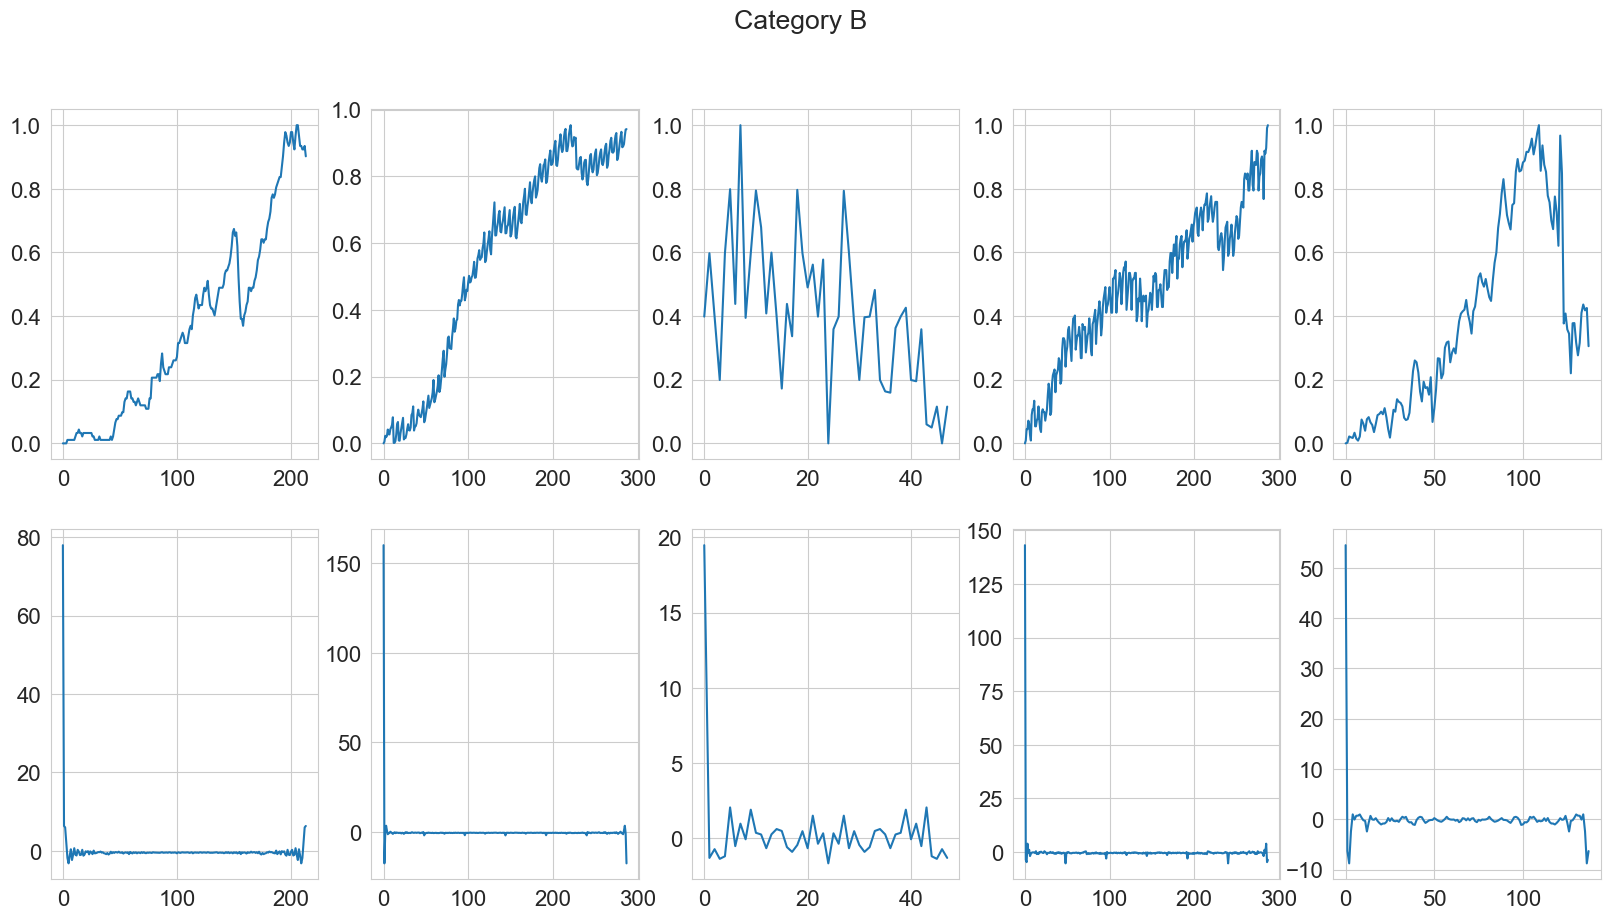

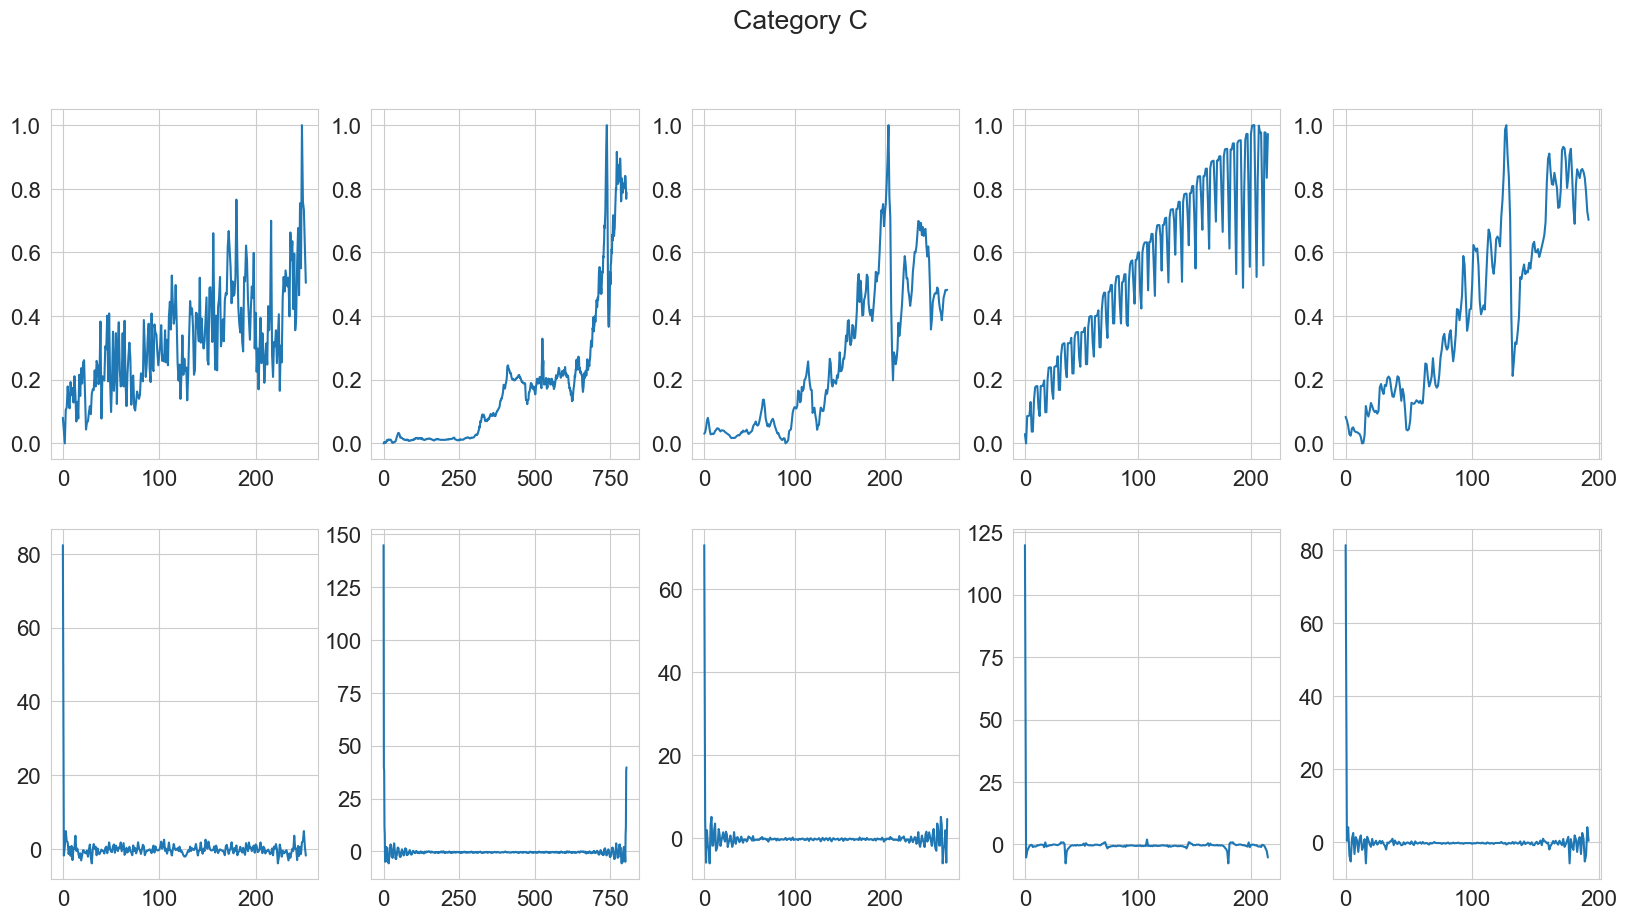

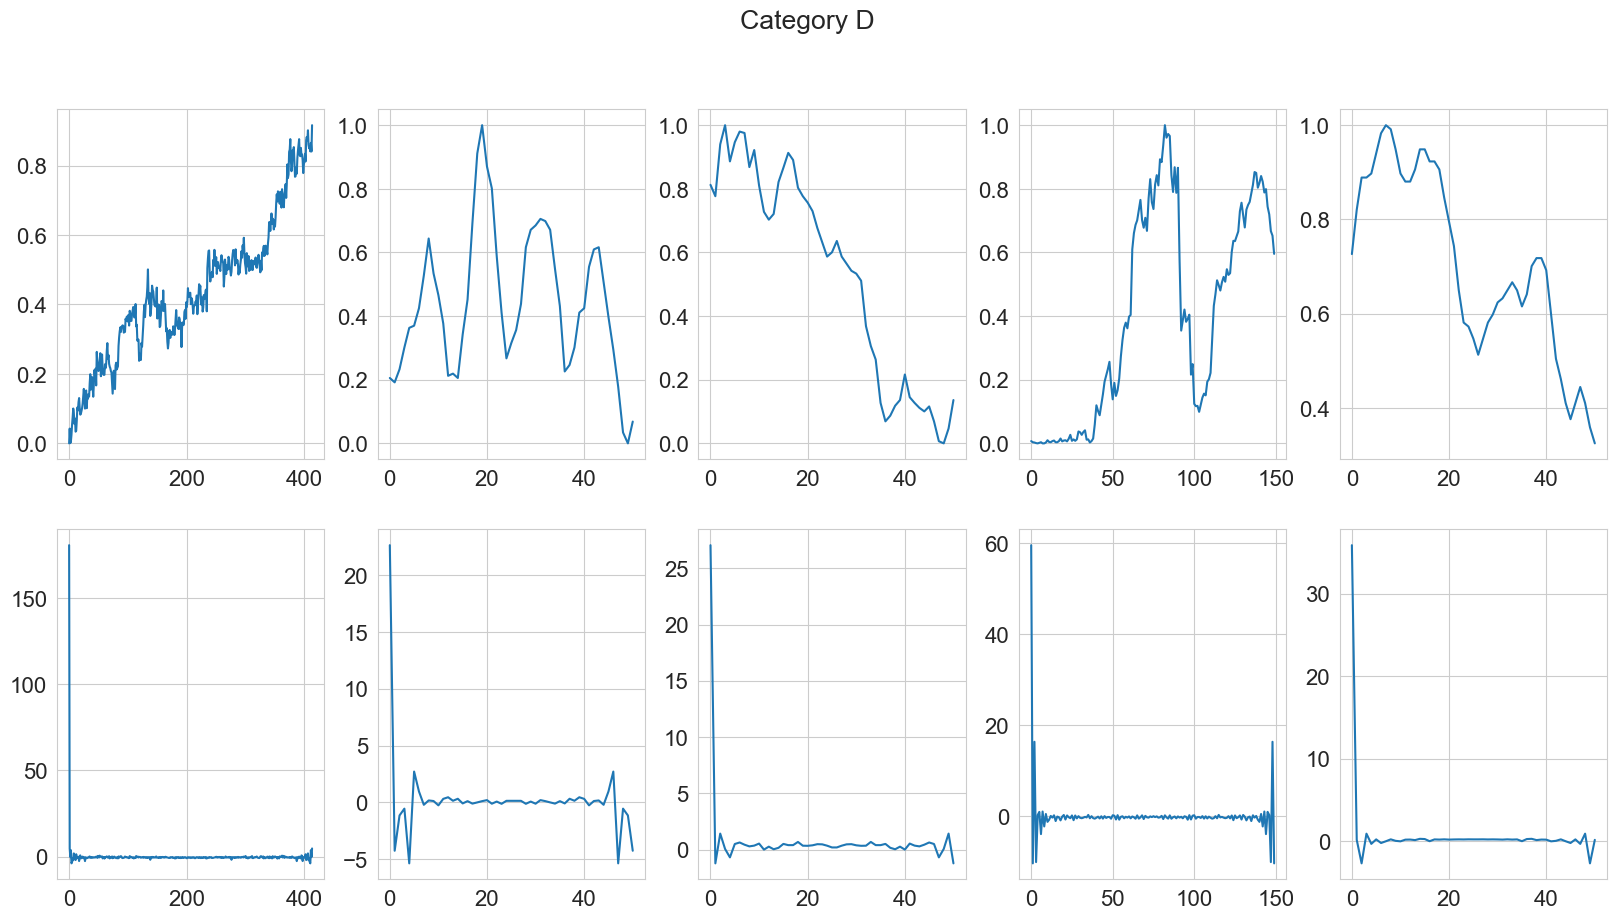

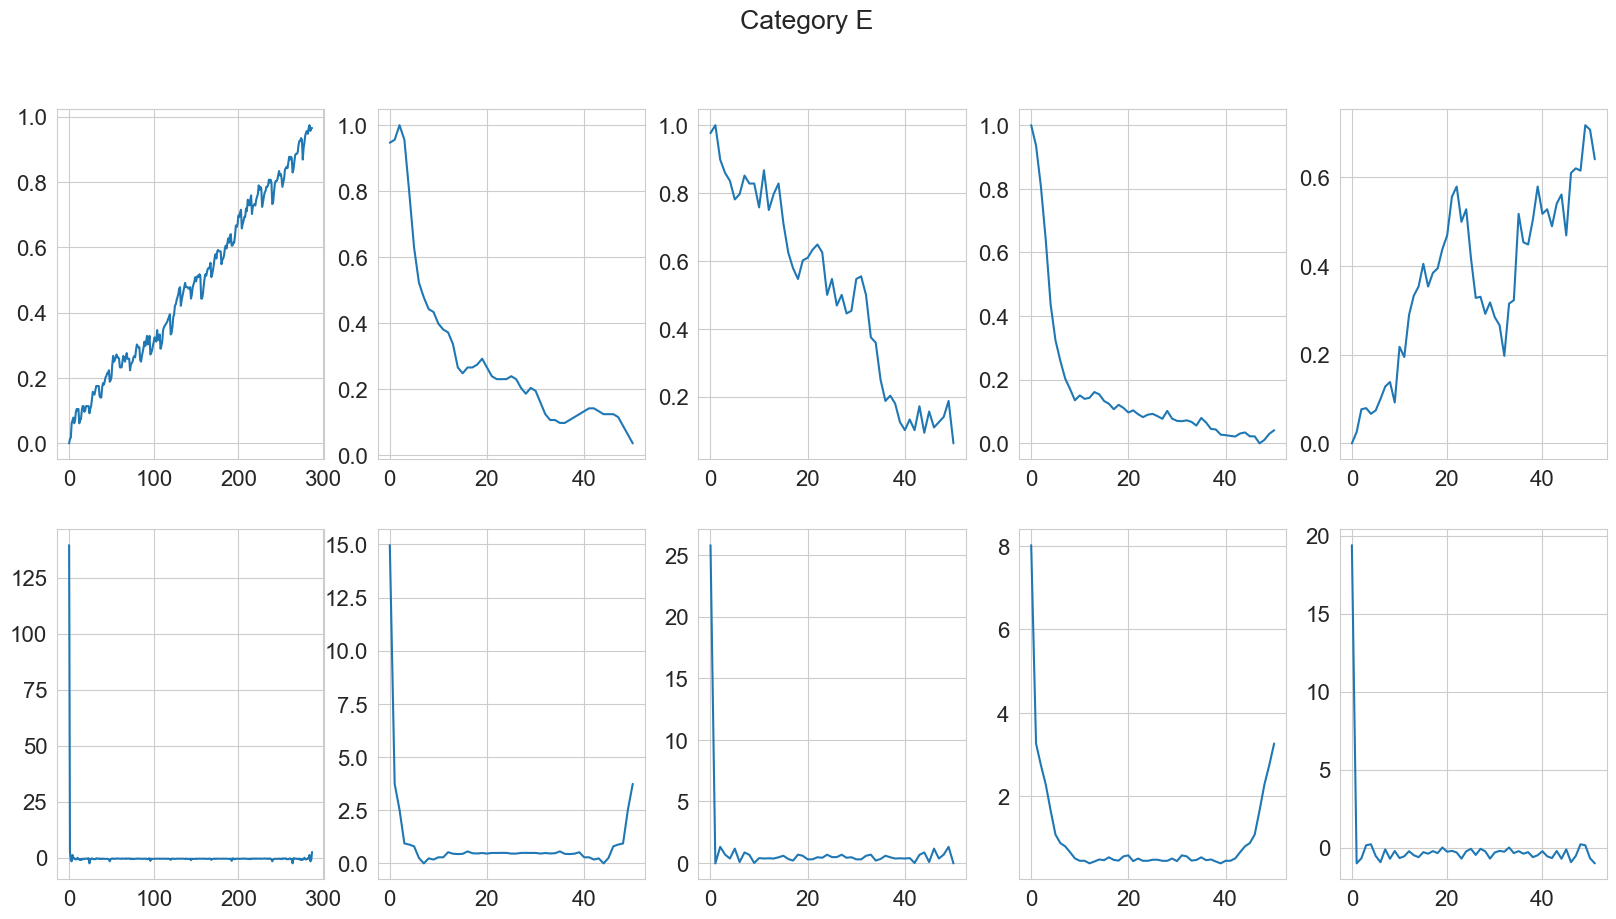

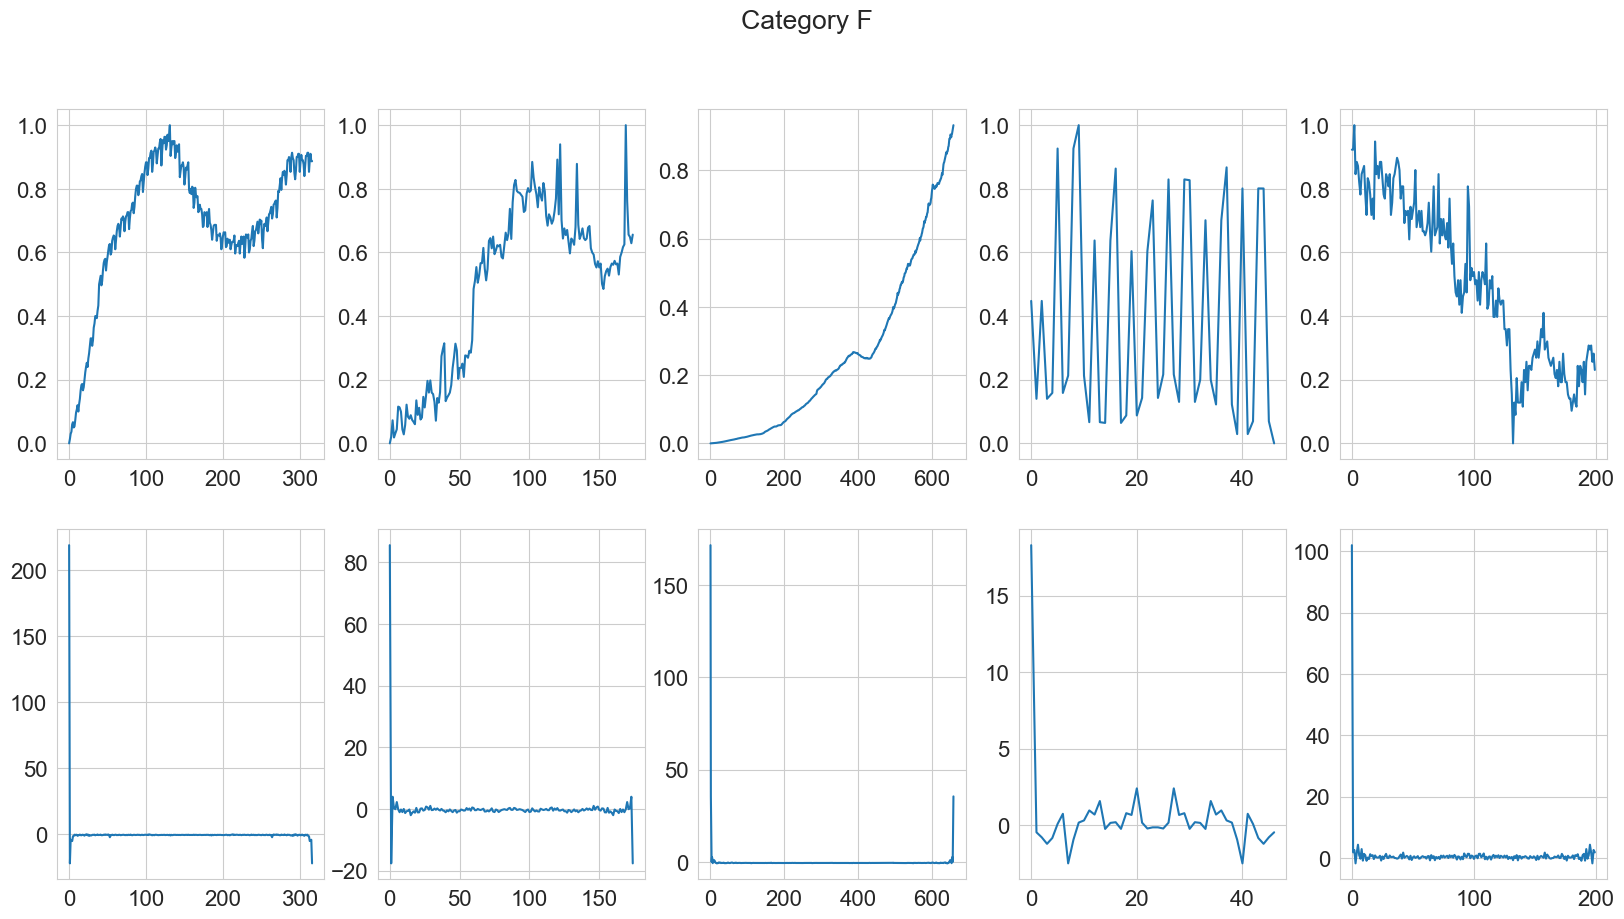

In [25]:
# Fourier Transformation

for c in np.unique(categories):
    n_samples = 5
    fig, axs = plt.subplots(2, n_samples, figsize=(20, 10))
    timeseries = training_data[categories==c]
    periods = valid_periods[categories==c]
    fig.suptitle("Category " + c)
    for i in range(n_samples):
        index = random.randrange(len(timeseries))
        ts = timeseries[index][periods[index, 0] : periods[index, 1]]
        axs[0, i].plot(ts)
        axs[1, i].plot(fft(ts))
    plt.show()
    plt.close()

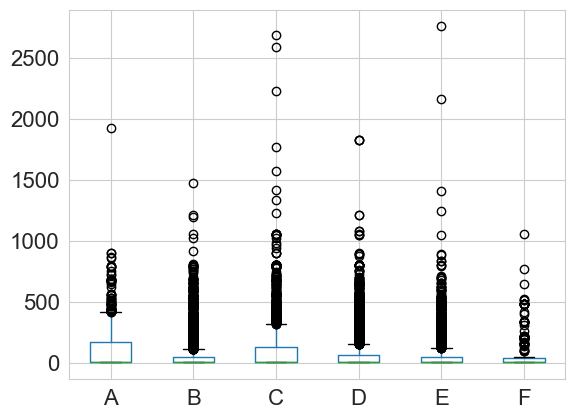

Number of timeseries with valid window size:
   total  valid  not valid         %
A   5728   5696         32  0.558659
B  10987  10690        297  2.703195
C  10017   9899        118  1.177997
D  10016   9833        183  1.827077
E  10975  10906         69  0.628702
F    277    272          5  1.805054
Window size mean for category :
A    88.061271
B    63.599906
C    85.744318
D    77.998373
E    69.399321
F    82.963235
dtype: float64


In [23]:
# Window size inference with fourier transform
plt.figure()
windowSizes = pd.DataFrame()
for c in np.unique(categories):
    timeseries = training_data[categories==c]
    periods = valid_periods[categories==c]
    ws = []
    for ts, p in zip(timeseries, periods):
        ac = fft(ts[p[0]:p[1]])
        ws.append(findMaxLocalMaxima(ac))
    ws = pd.DataFrame(ws, columns=[c])
    windowSizes = pd.concat([windowSizes, ws], axis=1)
windowSizes.boxplot()
plt.show()
plt.close()

print("Number of timeseries with valid window size:")
n_notValid = pd.concat([quantities, windowSizes.count()], axis=1)
n_notValid.columns = ['total', 'valid']
n_notValid['not valid'] = n_notValid['total'] - n_notValid['valid']
n_notValid['%'] = n_notValid['not valid'] / n_notValid['total'] * 100
print(n_notValid)

print("Window size mean for category :")
print(windowSizes.mean())